# **Predict Future Sales**

# **Dataset Description**
You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

**File descriptions**

**sales_train.csv** - the training set. Daily historical data from January 2013 to October 2015.

**test.csv** - the test set. You need to forecast the sales for these shops and products for November 2015.

**sample_submission.csv** - a sample submission file in the correct format.

**items.csv** - supplemental information about the items/products.

**item_categories.csv ** - supplemental information about the items categories.

**shops.csv**- supplemental information about the shops.

**Data fields**
**ID** - an Id that represents a (Shop, Item) tuple within the test set

**shop_id** - unique identifier of a shop

**item_id** - unique identifier of a product

**item_category_id** - unique identifier of item category

**item_cnt_day** - number of products sold. You are predicting a monthly
amount of this measure

**item_price** - current price of an item

**date** - date in format dd/mm/yyyy

**date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33


**item_name **- name of item

**shop_name** - name of shop

**item_category_name** - name of item category

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import warnings
from scipy import stats
warnings.simplefilter(action='ignore', category=FutureWarning)

# **Data Loading**

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Let's explicitly indicate data types when loading in order to optimize memory usage, prevent errors, speed up data loading, and enhance code readability by making it more efficient and understandable for other developers.

In [4]:
df_test = pd.read_csv('/content/drive/MyDrive/Predict Future Sales/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32',
                                                  'item_id': 'int32'})
df_item_cat = pd.read_csv('/content/drive/MyDrive/Predict Future Sales/item_categories.csv',
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
df_items = pd.read_csv('/content/drive/MyDrive/Predict Future Sales/items.csv', dtype={'item_name': 'str', 'item_id': 'int32',
                                                 'item_category_id': 'int32'})
df_shops = pd.read_csv('/content/drive/MyDrive/Predict Future Sales/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales_train = pd.read_csv('/content/drive/MyDrive/Predict Future Sales/sales_train.csv', parse_dates=['date'],
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32',
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

<ipython-input-4-616899ac076e>:8: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  sales_train = pd.read_csv('/content/drive/MyDrive/Predict Future Sales/sales_train.csv', parse_dates=['date'],


# **Data Quality Check (DQC)**

*Let's conduct a Data Quality Check on the combined dataset, instead of checking all the tables separately.Combine datasets.*

In [5]:
# Let's write a function for sequential merging of datasets using a common column
def sequential_left_merge(data, *datasets):
    merged_data = data.copy()  # Create a copy of the original data to preserve it

    # Define the common column for the first merge
    common_column = None

    # Iterate over each dataset
    for df in datasets:
        # Find the common column for merging
        if common_column is None:
            common_column = set(data.columns) & set(df.columns)
        else:
            common_column = list(set(merged_data.columns) & set(df.columns))

        # Perform left merge
        merged_data = pd.merge(merged_data, df, on=list(common_column), how='left')

    return merged_data

In [6]:
# Perform the sequential left merge of train data
merged_data = sequential_left_merge(sales_train, df_items, df_item_cat, df_shops)

In [7]:
# Perform the sequential left merge of train data
merged_data_test = sequential_left_merge(df_test, df_items, df_item_cat, df_shops)

# **Quickly check the completeness of the data**

In [8]:
# Data Quality Check (DQC)
def data_quality_check(data):
    try:
        # Check for missing values
        missing_values = data.isnull().sum()
        print("Missing Values:")
        print(missing_values)

        # Check for duplicates
        duplicates = data.duplicated().sum()
        print("\nDuplicates:")
        print(duplicates)

        # Check data types
        data_types = data.dtypes
        data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')
        print("\nData Types:")
        print(data_types)

    except KeyError:
        print("Error: 'date' column not found in the DataFrame.")

# Perform Data Quality Check
print("Data Quality Check 'merged_data':")
data_quality_check(merged_data)
merged_data.describe()

Data Quality Check 'merged_data':
Missing Values:
date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
shop_name             0
dtype: int64

Duplicates:
6

Data Types:
date                  datetime64[ns]
date_block_num                 int32
shop_id                        int32
item_id                        int32
item_price                   float32
item_cnt_day                   int32
item_name                     object
item_category_id               int32
item_category_name            object
shop_name                     object
dtype: object


,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00
std,9.42,16.23,6324.30,1729.80,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


In [9]:
print("Data Quality Check 'merged_data_test':")
data_quality_check(merged_data_test)
merged_data.describe()

Data Quality Check 'merged_data_test':
Missing Values:
ID                    0
shop_id               0
item_id               0
item_name             0
item_category_id      0
item_category_name    0
shop_name             0
dtype: int64

Duplicates:
0
Error: 'date' column not found in the DataFrame.


,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00
std,9.42,16.23,6324.30,1729.80,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


# **Duplicates**
Let's remove duplicates. By duplicates we mean positions in which the column values ​​are the same ['date','date_block_num','shop_id','item_id','item_price','item_cnt_day']

In [86]:
df = merged_data.copy()

In [89]:
def drop_duplicate(data, subset):
    """
    Remove duplicate rows from the DataFrame based on the specified subset of columns.

    Parameters:
    - data: pandas.DataFrame, the DataFrame to remove duplicates from.
    - subset: list of str, the subset of columns to consider when identifying duplicates.

    Returns:
    - dup_filted_df: pandas.DataFrame, the DataFrame without duplicate rows.
    """
    dup_filted_df = data.copy()
    print('Before drop shape:', dup_filted_df.shape)
    before = dup_filted_df.shape[0]
    dup_filted_df.drop_duplicates(subset=subset, keep='first', inplace=True)
    dup_filted_df.reset_index(drop=True, inplace=True)
    print('After drop shape:', dup_filted_df.shape)
    after = dup_filted_df.shape[0]
    print('Total Duplicate:', before - after)

    return dup_filted_df

subset = ['date', 'shop_id', 'item_id', 'item_price']
dup_filted_df_result = drop_duplicate(df, subset=subset)

Before drop shape: (2935825, 11)
After drop shape: (2935825, 11)
Total Duplicate: 0


# **Analyze the completeness**
Let's analyze the completeness of the training dataset and testing dataset in both directions to find out which positions ('shop_id', 'item_id', 'item_category_id') are present in the test dataset but not in the training dataset and vice versa.

In [10]:
# Let's create a column for fixing the store-product couplings we need
merged_data_test['shop_item_id'] = merged_data_test.apply(lambda row: str(row['shop_id']) + '-' + str(row['item_id']), axis=1)
merged_data['shop_item_id'] = merged_data.apply(lambda row: str(row['shop_id']) + '-' + str(row['item_id']), axis=1)

In [11]:
def check_completeness(train, test, columns=['shop_id', 'item_id', 'item_category_id', 'shop_item_id']):
    """
    Check the completeness of specified columns between train and test datasets.

    Args:
        train (DataFrame): The training dataset.
        test (DataFrame): The testing dataset.
        columns (list, optional): List of column names to check completeness. Default is ['shop_id', 'item_id', 'item_category_id', 'shop_item_id'].

    Returns:
        list: A list of formatted strings presenting completeness analysis results for each specified column.
    """
    completeness_results = {}

    for col in columns:
        train_values = set(train[col].unique())
        test_values = set(test[col].unique())

        missing_in_train = test_values - train_values
        missing_in_test = train_values - test_values

        completeness_results[col] = {
            'missing_in_train': missing_in_train,
            'missing_in_test': missing_in_test
        }

    # Format the results for clearer presentation
    formatted_results = []
    for col, result in completeness_results.items():
        formatted_results.append(f"Result of completeness analysis for '{col}': "
                                  f"Missing in train: {len(result['missing_in_train'])}, "
                                  f"Missing in test: {len(result['missing_in_test'])}")

    return formatted_results

completeness_results = check_completeness(merged_data, merged_data_test)
for result in completeness_results:
    print(result)

Result of completeness analysis for 'shop_id': Missing in train: 0, Missing in test: 18
Result of completeness analysis for 'item_id': Missing in train: 363, Missing in test: 17070
Result of completeness analysis for 'item_category_id': Missing in train: 0, Missing in test: 22
Result of completeness analysis for 'shop_item_id': Missing in train: 102796, Missing in test: 312720


In [ ]:
# Let's select only the observations we need
list_test = set(merged_data_test.shop_item_id)
intersect_train = merged_data[merged_data.shop_item_id.isin(list_test)]
mean_intersect_train = pd.DataFrame(intersect_train.groupby(['shop_item_id','date_block_num'])['date_block_num'].mean())
mean_intersect_train.date_block_num.mean()

20.158762927824128

# **Checking string predictors.**

A study of store names helped identify a system error - in four cases, store names differed by several characters, although they meant (let's say) the same object. Let's replace the shop_name and shop_id of these objects so that they merge into one shop_id, moreover, the one that is present in df_test

In [34]:
print(merged_data.loc[merged_data['shop_id'] == 11,'shop_name'].iloc[0] + " - " + merged_data.loc[merged_data['shop_id'] == 10,'shop_name'].iloc[0])
print(merged_data.loc[merged_data['shop_id'] == 0,'shop_name'].iloc[0] + " - " + merged_data.loc[merged_data['shop_id'] == 57,'shop_name'].iloc[0])
print(merged_data.loc[merged_data['shop_id'] == 1,'shop_name'].iloc[0] + " - " + merged_data.loc[merged_data['shop_id'] == 58,'shop_name'].iloc[0])
print(merged_data.loc[merged_data['shop_id'] == 40,'shop_name'].iloc[0] + " - " + merged_data.loc[merged_data['shop_id'] == 39,'shop_name'].iloc[0])

Жуковский ул. Чкалова 39м² - Жуковский ул. Чкалова 39м?
!Якутск Орджоникидзе, 56 фран - Якутск Орджоникидзе, 56
!Якутск ТЦ "Центральный" фран - Якутск ТЦ "Центральный"
РостовНаДону ТРК "Мегацентр Горизонт" Островной - РостовНаДону ТРК "Мегацентр Горизонт"


Let's think that these are the same stores and replace our values ​​in train

In [117]:
df = merged_data.copy()
df.loc[df['shop_id'] == 0, 'shop_id'] = 57
df.loc[df['shop_id'] == 1, 'shop_id'] = 58
df.loc[df['shop_id'] == 11, 'shop_id'] = 10
df.loc[df['shop_id'] == 40, 'shop_id'] = 39


The names do not need to be replaced, since we will delete them later, generating from it an additional sign based on the cleared word, which will be the same

# **Let's see if there are system outliers in the dataset**

<Axes: ylabel='item_cnt_day'>

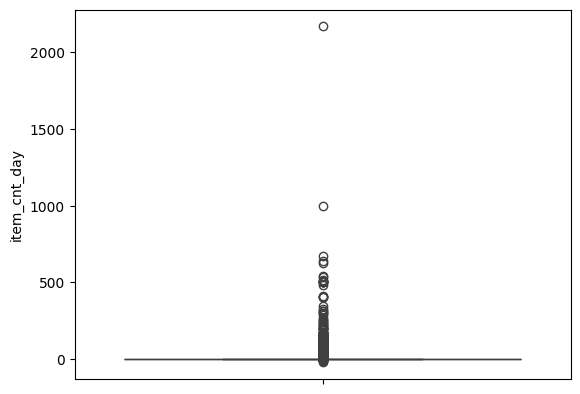

In [37]:
sns.boxplot(y='item_cnt_day', data=merged_data)

<Axes: ylabel='item_price'>

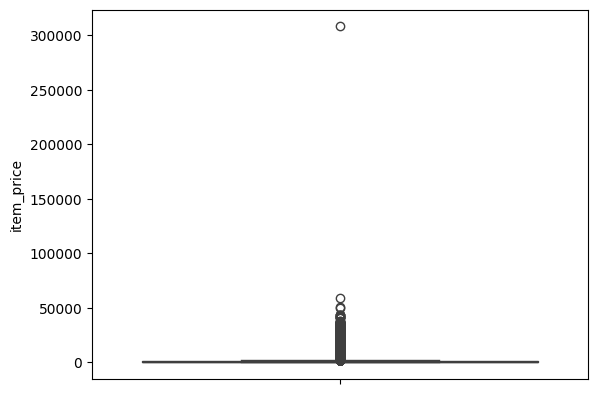

In [73]:
sns.boxplot(y='item_price', data=df)

In [65]:
def top_10_items(df):
    top_items = df.nlargest(10, 'item_cnt_day')
    for index, row in top_items.iterrows():
        item_name = row['item_name']
        quantity = row['item_cnt_day']
        mean_quantity = df[df['item_name'] == item_name]['item_cnt_day'].mean()
        print(f"Item name: {item_name}, Quantity: {quantity}, Mean quantity: {mean_quantity}")

# Пример использования функции
top_10_items(df)

Item name: Доставка до пункта выдачи (Boxberry), Quantity: 2169, Mean quantity: 14.144396551724139
Item name: Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм, Quantity: 1000, Mean quantity: 5.987300574345884
Item name: Билет "ИгроМир 2015" - 3 октября 2015 (сайт) [Цифровая версия], Quantity: 669, Mean quantity: 27.934426229508198
Item name: Билет "ИгроМир 2015" - 3 октября 2015 (сайт) УПР [Цифровая версия], Quantity: 637, Mean quantity: 27.934426229508198
Item name: Grand Theft Auto V [PC, русские субтитры], Quantity: 624, Mean quantity: 4.290144435004248
Item name: Доставка до пункта выдачи (Boxberry), Quantity: 539, Mean quantity: 14.144396551724139
Item name: Билет "ИгроМир 2015" - 3 октября 2015 (сайт) УПР [Цифровая версия], Quantity: 533, Mean quantity: 27.934426229508198
Item name: Билет "ИгроМир 2014" (на один день (отдельно - 4, 5 октября 2014)), Quantity: 512, Mean quantity: 7.181102362204724
Item name: Средиземье: Тени Мордора [PC, Цифровая версия], Quantity: 508, Mean 

At the loading stage, let's consider as system emissions those positions for which the number of sales was more than 100 times the average sales value for this product, and let's consider as system emissions those positions for which price was more than 10 times the average price for this product

In [98]:
def remove_outliers(df):
    # Рассчитываем среднее значение продаж и цены по каждому товару
    mean_quantity_by_item = df.groupby('item_name')['item_cnt_day'].mean()
    mean_price_by_item = df.groupby('item_name')['item_price'].mean()

    # Фильтруем строки, где количество продаж или цена больше, чем в 100 раз среднее значение по соответствующему товару
    outliers_quantity = df[df['item_cnt_day'] > 100 * df['item_name'].map(mean_quantity_by_item)]
    outliers_price = df[df['item_price'] > 10 * df['item_name'].map(mean_price_by_item)]
    # outliers_price1 = df[df['item_price'] < 100 * df['item_name'].map(mean_price_by_item)]

    # Удаляем найденные выбросы из датасета
    df = df.drop(outliers_quantity.index)
    df = df.drop(outliers_price.index)
    # df = df.drop(outliers_price1.index)

    return df

# Пример использования функции
df_cleaned = remove_outliers(df)
print(f'The number of observations after clearing emissions decreased by {len(df) - len(df_cleaned)}')

The number of observations after clearing emissions decreased by 50


In [108]:
#Let's find if there is such a position in the test before deleting
max_item_id = df.loc[df['item_price'] == df['item_price'].nlargest(1).iloc[-1], 'item_id'].values[0]
if max_item_id in df_test['item_id'].values:
    print("Позиция с max_item_id найдена в столбце item_id.")
else:
    print("Позиция с max_item_id не найдена в столбце item_id.")

Позиция с max_item_id найдена в столбце item_id.


In [109]:
max_item_price = df.loc[df['item_price'] == df['item_price'].nlargest(1).iloc[-1], 'item_id'].values[0]
df_cleaned = df_cleaned[df_cleaned['item_price'] != max_item_price]

In [118]:
def remove_outliers(df):
    """
    Removes outliers from the DataFrame based on item sales quantity and price.

    Parameters:
    - df: pandas.DataFrame, the DataFrame to clean.

    Returns:
    - df_cleaned: pandas.DataFrame, the cleaned DataFrame.
    """
    # Calculate the mean quantity and price for each item
    mean_quantity_by_item = df.groupby('item_name')['item_cnt_day'].mean()
    mean_price_by_item = df.groupby('item_name')['item_price'].mean()

    # Filter rows where the quantity or price exceeds 100 times the mean value for the respective item
    outliers_quantity = df[df['item_cnt_day'] > 100 * df['item_name'].map(mean_quantity_by_item)]
    outliers_price = df[df['item_price'] > 100 * df['item_name'].map(mean_price_by_item)]

    # Find the item with the maximum price
    max_price_item = df.loc[df['item_price'].idxmax(), 'item_name']

    # Remove outliers and the item with the maximum price from the dataset
    df_cleaned = df.drop(outliers_quantity.index)
    df_cleaned = df_cleaned.drop(outliers_price.index)
    df_cleaned = df_cleaned[df_cleaned['item_name'] != max_price_item]

    return df_cleaned

# Example usage of the function
df_cleaned = remove_outliers(df)
print(f'The number of observations after clearing outliers decreased by {len(df) - len(df_cleaned)}')


The number of observations after clearing outliers decreased by 22


<Axes: ylabel='item_price'>

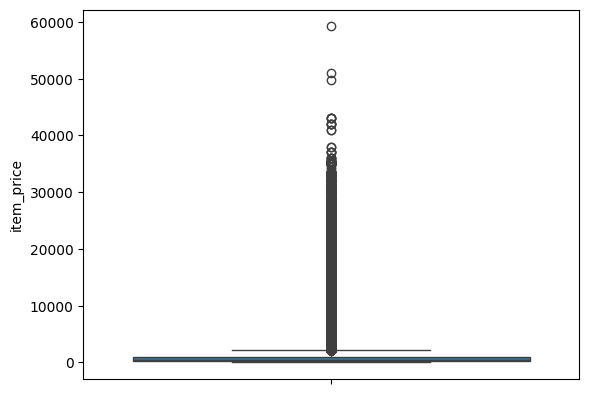

In [119]:
sns.boxplot(y='item_price', data=df_cleaned)

<Axes: ylabel='item_cnt_day'>

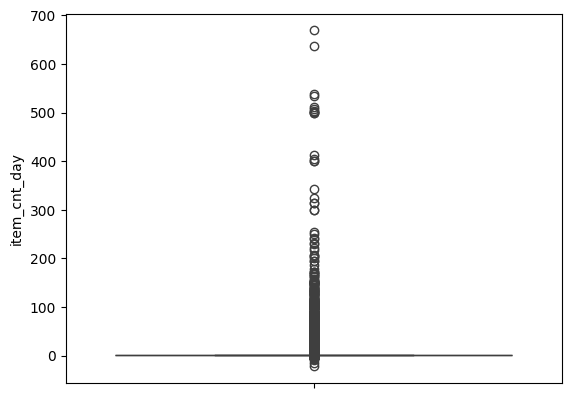

In [120]:
sns.boxplot(y='item_cnt_day', data=df_cleaned)


# **CONCLUSIONS ABOUT THE COMPLETENESS OF THE TRAINING SET**
**We are dealing with a very incomplete training set:**

1. The training sample contains all the stores and product categories that are in the test, but it lacks observations for 363 product positions.

2. The number of store-product couplings present in test, but absent in train: 102796, which is 33.0% of the number of observations. Moreover, according to the existing observations of store-product links, the average number of monthly data is 20, instead of 33.

**How ​​much larger is the training set than the test set:**

The number of excess magazines in the training set is 18.

The number of excess products in the training set is 17070 items.

The number of redundant product categories in the training set is 22.

Number of elements present in train but not in test: 312720.

3. The merged dataframe does not contain duplicates based on matching column values ​​['date', 'shop_id', 'item_id', 'item_price'], which means there is no need to delete duplicates.

4. The data contains 4 duplicate store names; the shop_id of these stores needs to be replaced.

5. The data contains system outliers and there is a need to remove from the data items for which the number of sales was more than 100 times the average sales value for this product, and for which price was more than 10 times the average price for this product. And it’s worth removing another position with the maximum price, because... it is a clear outlier and this position is not in the training set



# **What the ELT process should look like based on the results of the DQC study:**
1. Load the dataset, explicitly specifying the types.
2. We combine all datasets into one dataset
3. Changing duplicate store names
3. We remove outliers that we have identified

In [140]:
import pandas as pd

class ELTclass:
    def __init__(self, item_cat_path, items_path, shops_path, sales_train_path):
        self.item_cat_path = item_cat_path
        self.items_path = items_path
        self.shops_path = shops_path
        self.sales_train_path = sales_train_path

    def read_data(self):
        df_item_cat = pd.read_csv(self.item_cat_path, dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
        df_items = pd.read_csv(self.items_path, dtype={'item_name': 'str', 'item_id': 'int32', 'item_category_id': 'int32'})
        df_shops = pd.read_csv(self.shops_path, dtype={'shop_name': 'str', 'shop_id': 'int32'})
        sales_train = pd.read_csv(self.sales_train_path, parse_dates=['date'], dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})
        return df_item_cat, df_items, df_shops, sales_train

    def get_merged_data(self):
        df_item_cat, df_items, df_shops, sales_train = self.read_data()
        merged_data = sales_train.copy()  # Create a copy of the original data to preserve it
        # Define the common column for the first merge
        common_column = None
        # Iterate over each dataset
        for df in [df_items, df_item_cat, df_shops]:
            # Find the common column for merging
            if common_column is None:
                common_column = set(merged_data.columns) & set(df.columns)
            else:
                common_column = list(set(merged_data.columns) & set(df.columns))

            # Perform left merge
            merged_data = pd.merge(merged_data, df, on=list(common_column), how='left')
            merged_data['date'] = pd.to_datetime(merged_data['date'], format='%d.%m.%Y')

        return merged_data

    def update_shop_ids(self, data):
        """
        Update shop IDs in the DataFrame to adjust them to a specific mapping.

        Parameters:
        - data: pandas.DataFrame, the DataFrame containing the shop IDs to update.

        Returns:
        - updated_data: pandas.DataFrame, the DataFrame with updated shop IDs.
        """
        updated_data = data.copy()
        updated_data.loc[updated_data['shop_id'] == 0, 'shop_id'] = 57
        updated_data.loc[updated_data['shop_id'] == 1, 'shop_id'] = 58
        updated_data.loc[updated_data['shop_id'] == 11, 'shop_id'] = 10
        updated_data.loc[updated_data['shop_id'] == 40, 'shop_id'] = 39

        return updated_data

    def remove_outliers(self, df):
        """
        Removes outliers from the DataFrame based on item sales quantity and price.

        Parameters:
        - df: pandas.DataFrame, the DataFrame to clean.

        Returns:
        - df_cleaned: pandas.DataFrame, the cleaned DataFrame.
        """
        # Calculate the mean quantity and price for each item
        mean_quantity_by_item = df.groupby('item_name')['item_cnt_day'].mean()
        mean_price_by_item = df.groupby('item_name')['item_price'].mean()

        # Filter rows where the quantity or price exceeds 100 times the mean value for the respective item
        outliers_quantity = df[df['item_cnt_day'] > 100 * df['item_name'].map(mean_quantity_by_item)]
        outliers_price = df[df['item_price'] > 100 * df['item_name'].map(mean_price_by_item)]

        # Find the item with the maximum price
        max_price_item = df.loc[df['item_price'].idxmax(), 'item_name']

        # Remove outliers and the item with the maximum price from the dataset
        df_cleaned = df.drop(outliers_quantity.index)
        df_cleaned = df_cleaned.drop(outliers_price.index)
        df_cleaned = df_cleaned[df_cleaned['item_name'] != max_price_item]

        return df_cleaned
# Example usage of the class
item_cat_path = '/content/drive/MyDrive/Predict Future Sales/item_categories.csv'
items_path = '/content/drive/MyDrive/Predict Future Sales/items.csv'
shops_path = '/content/drive/MyDrive/Predict Future Sales/shops.csv'
sales_train_path = '/content/drive/MyDrive/Predict Future Sales/sales_train.csv'

elt = ELTclass(item_cat_path=item_cat_path, items_path=items_path, shops_path=shops_path, sales_train_path=sales_train_path)
# Get merged data
merged_data = elt.get_merged_data()

# # Update shop IDs
updated_data = elt.update_shop_ids(merged_data)

# # Removes outliers
filtered_data = elt.remove_outliers(updated_data)

filtered_data.shape

<ipython-input-140-5f1cfa1adb63>:14: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  sales_train = pd.read_csv(self.sales_train_path, parse_dates=['date'], dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,2013-03-01,0,25,2552,899.00,1,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,2013-05-01,0,25,2552,899.00,-1,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,2013-06-01,0,25,2554,1709.05,1,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,2013-01-15,0,25,2555,1099.00,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""
...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1,V/A Nu Jazz Selection (digipack),55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
2935845,2015-09-10,33,25,7460,299.00,1,V/A The Golden Jazz Collection 1 2CD,55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
2935846,2015-10-14,33,25,7459,349.00,1,V/A The Best Of The 3 Tenors,55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
2935847,2015-10-22,33,25,7440,299.00,1,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,Музыка - MP3,"Москва ТРК ""Атриум"""


In [141]:
filtered_data.shape

(2935827, 10)